# Cats vs Dogs / Lesson 1 of fast.ai MOOC

This notebook is a log of what I've learned so far during the course. Mostly a reminder for myself. This notebook will demonstrate the entire process of preparing for and submitting to a kaggle competition, the dogs-vs-cats-redux-kernels-edition competition to be exact. It will use the fast.ai classes from lesson 1

In [3]:
competitionName = "dogs-vs-cats-redux-kernels-edition"


u'/home/ubuntu/nbs/fastAI'

In [4]:
import os, sys
from shutil import copyfile
import numpy as np
current_dir = os.getcwd()
notebookPath = current_dir
dataPath = current_dir + "/" + "kaggle" + "/" + competitionName


# Prepare all the data using the kaggle-cli

In [8]:
%cd $notebookPath
%mkdir -p $dataPath
%cd $dataPath
# Need to have kaggle-cli installed and configured for this to work
#!kg download -c $competitionName
# Unzip the data (need to have unzip installed for this to work) suppress the output
#!unzip train.zip $dataPath >> /dev/null
#!unzip test.zip $dataPath >> /dev/null
#%rm test.zip
#%rm train.zip

%mkdir -p valid
%mkdir -p results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown



/home/ubuntu/nbs/fastAI
/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition


## Prepare the validation set
Use a random batch of the training data and use it for the validation set


In [ ]:
from glob import glob
import numpy as np

In [21]:
nrValidationSamples = 2000
%cd $dataPath/train
%pwd
files = glob("*.jpg")
shuffledFiles = np.random.permutation(files)
shuffledFiles[:5]
for i in range(nrValidationSamples): os.rename(shuffledFiles[i], dataPath + '/valid/' + shuffledFiles[i])


/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/train


In [22]:
%cd $dataPath/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/valid


## Prepare the sample set
Use a few samples to quickly check the model, copy the files instead of moving

In [25]:
nrTrainSamples = 200
%cd $dataPath/train
%pwd
files = glob("*.jpg")
shuffledFiles = np.random.permutation(files)
for i in range(nrTrainSamples): copyfile(shuffledFiles[i], dataPath + '/sample/train/' + shuffledFiles[i])


/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/train


In [27]:
%cd $dataPath/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/sample/train


In [26]:
nrValidSamples = 200
%cd $dataPath/train
%pwd
files = glob("*.jpg")
shuffledFiles = np.random.permutation(files)
for i in range(nrValidSamples): copyfile(shuffledFiles[i], dataPath + '/sample/valid/' + shuffledFiles[i])


/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/train


In [28]:
%cd $dataPath/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/sample/valid


In [3]:
#Go back to main folder
%cd ../../

[Errno 2] No such file or directory: 'kaggle/dogs-vs-cats-redux-kernels-edition'
/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition
/home/ubuntu/nbs/fastAI


# New heading

In [1]:
%matplotlib inline
import theano
import keras
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots
import pandas as pd

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [50]:
from vgg16 import Vgg16
path = "data/dogscats/"
test = "data/dogscats/kaggle/test/"
vgg = Vgg16()

In [51]:
batch_size = 32
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
test_batches = vgg.get_batches(test, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [52]:
vgg.finetune(batches)
vgg.fit(batches,val_batches,nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 685s - loss: 0.2235 - acc: 0.9696 - val_loss: 0.1620 - val_acc: 0.9810


## Use the validation data to test the accuracy

In [5]:
img,labels=next(batches)
labels

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]], dtype=float32)

In [6]:

img,labels=next(batches)
res = vgg.predict(img,True)
labels = ['{:.4f}'.format(x) + " " + y for x,y in zip(res[0],res[2])]
plots(img,titles=labels)

NameError: name 'files' is not defined

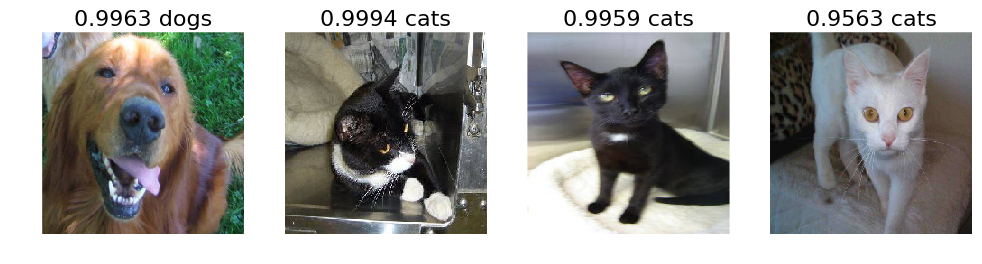

In [7]:
img,labels=next(test_batches)
res = vgg.predict(img,True)
labels = ['{:.4f}'.format(x) + " " + y for x,y in zip(res[0],res[2])]
plots(img,titles=labels)

# Prepare for submission to Kaggle

First get the predictions for the test dataset. The batches variable holds the iterator to the test filenames and the preds gives a label with a confidence prediction. (1 = dog, 0 = cat).

In [54]:
batches, preds = vgg.test(test,batch_size=64)

    

Found 12500 images belonging to 1 classes.


In [55]:
f = batches.filenames[0]
ids = [f[f.find("/")+1:f.find(".")] for f in batches.filenames]

In [71]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
submission = pd.DataFrame({'id':ids, 'label': preds[:,1]})
submission.head



<bound method DataFrame.head of           id         label
0       9292  2.706077e-35
1      12026  4.632690e-01
2       9688  1.959045e-25
3       4392  0.000000e+00
4        779  1.000000e+00
5       2768  1.000000e+00
6       2399  5.551384e-41
7      12225  1.607432e-01
8      10947  1.362464e-39
9       1780  7.248619e-32
10     11631  3.114882e-32
11      8478  1.000000e+00
12      7940  3.187393e-41
13      5102  8.730089e-43
14      1704  1.000000e+00
15      5967  1.996634e-24
16      1261  1.000000e+00
17     11882  1.000000e+00
18      3237  1.000000e+00
19     10222  1.000000e+00
20     10854  1.000000e+00
21      6810  2.810650e-09
22      8615  1.000000e+00
23      6014  6.448107e-19
24      7161  1.000000e+00
25      7934  1.000000e+00
26      6549  1.000000e+00
27      2715  0.000000e+00
28      6139  1.000000e+00
29      6873  1.961818e-44
...      ...           ...
12470  10292  4.125594e-29
12471  12254  1.000000e+00
12472  10119  1.000000e+00
12473    324  1.612962e

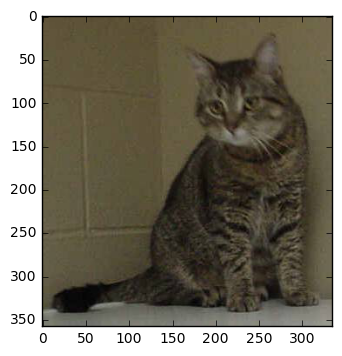

In [81]:
f = test + batches.filenames[12]
img=mpimg.imread(f)
imgplot = plt.imshow(img)


In [82]:
submission.to_csv("submission.csv", index=False)